In [ ]:
# Imports
import numpy as np
import pickle
import matplotlib.pyplot as plt
from scipy.optimize import minimize

from qiskit import *
from qiskit.visualization import *
from qiskit_aer import Aer
from qiskit.primitives import Estimator

In [ ]:
# =======================================================================
# ====================== Load data from files ===========================
# =======================================================================

# ================= Hamiltonian =====================

with open("data/hamiltonian.pkl", "rb") as f:
    hamiltonian = pickle.load(f)

print("===================================================")
print(f"Hamiltoniano: \n{hamiltonian}")
print("===================================================\n")


# ================= Nuclear repulsion =====================

with open("data/nuclear_repulsion.pkl", "rb") as f:
    nuclear_repulsion = pickle.load(f)

print("===================================================")
print(f"Energía nuclear: {nuclear_repulsion}")
print("===================================================\n")


# ================= Ansatz =====================

with open("data/ansatz.pkl", "rb") as f:
    ansatz= pickle.load(f)

Hamiltoniano: 
SparsePauliOp(['IIIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIZ', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIZI', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIZZ', 'IIIIIIIIIIIIIIIIIIIIIIIIIYZZYI', 'IIIIIIIIIIIIIIIIIIIIIIIIIYZZYZ', 'IIIIIIIIIIIIIIIIIIIIIIIIIXZZXI', 'IIIIIIIIIIIIIIIIIIIIIIIIIXZZXZ', 'IIIIIIIIIIIIIIIIIIIIIIYZZZZZYI', 'IIIIIIIIIIIIIIIIIIIIIIYZZZZZYZ', 'IIIIIIIIIIIIIIIIIIIIIIXZZZZZXI', 'IIIIIIIIIIIIIIIIIIIIIIXZZZZZXZ', 'IIIIIIIIIIIIIIIIIIIIYZZZZZZZYI', 'IIIIIIIIIIIIIIIIIIIIYZZZZZZZYZ', 'IIIIIIIIIIIIIIIIIIIIXZZZZZZZXI', 'IIIIIIIIIIIIIIIIIIIIXZZZZZZZXZ', 'IIIIIIIIIIIIIIIYZZZZZZZZZZZZYI', 'IIIIIIIIIIIIIIIYZZZZZZZZZZZZYZ', 'IIIIIIIIIIIIIIIXZZZZZZZZZZZZXI', 'IIIIIIIIIIIIIIIXZZZZZZZZZZZZXZ', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIZII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIZIZ', 'IIIIIIIIIIIIIIIIIIIIIIIIIIYYII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIYYIZ', 'IIIIIIIIIIIIIIIIIIIIIIIIIIXXII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIXXIZ', 'IIIIIIIIIIIIIIIIIIIIIIIIYZZYII', 'IIIIIIIIIIIIIIIIIIIIIIIIYZZYIZ', 'IIIIIIIIIIIIIIIII

In [ ]:
# Local simulator
simulator = Aer.get_backend('qasm_simulator')

# Initialization of parameters
x0 = np.zeros(ansatz.num_parameters)
print(ansatz.num_parameters)

# Diccionario para almacenar la evolución del costo
cost_history_dict = {
    "prev_vector": None,
    "iters": 0,
    "cost_history": [],
}

# Función de coste
def cost_func(params, ansatz, hamiltonian, estimator):
    job = estimator.run([ansatz], [hamiltonian], [params])
    result = job.result()
    energy = result.values[0]

    cost_history_dict["iters"] += 1
    cost_history_dict["prev_vector"] = params
    cost_history_dict["cost_history"].append(energy)

    print(f"Iteración {cost_history_dict['iters']}: Energía = {energy}")

    return energy

# Creamos el estimador para el simulador
estimator = Estimator()

# Ejecutamos la optimización
res = minimize(
    cost_func,
    x0,
    args=(ansatz, hamiltonian, estimator),
    method="COBYLA",
)

# Resultado final
print("Parámetros óptimos:", res.x)
print("Energía mínima encontrada:", res.fun)

# Graficar evolución del costo
fig, ax = plt.subplots()
ax.plot(range(cost_history_dict["iters"]), cost_history_dict["cost_history"])
ax.set_xlabel("Iteraciones")
ax.set_ylabel("Energía")
plt.show()

1764


MemoryError: Unable to allocate 16.0 GiB for an array with shape (1073741824,) and data type complex128

In [ ]:
# energy = -82.74018905934595 + nuclear_repulsion
energy = res.fun + nuclear_repulsion
print(f"Energía total: {energy}")

Energía nuclear: 9.193913160623385
Energía total: -74.99997897148256


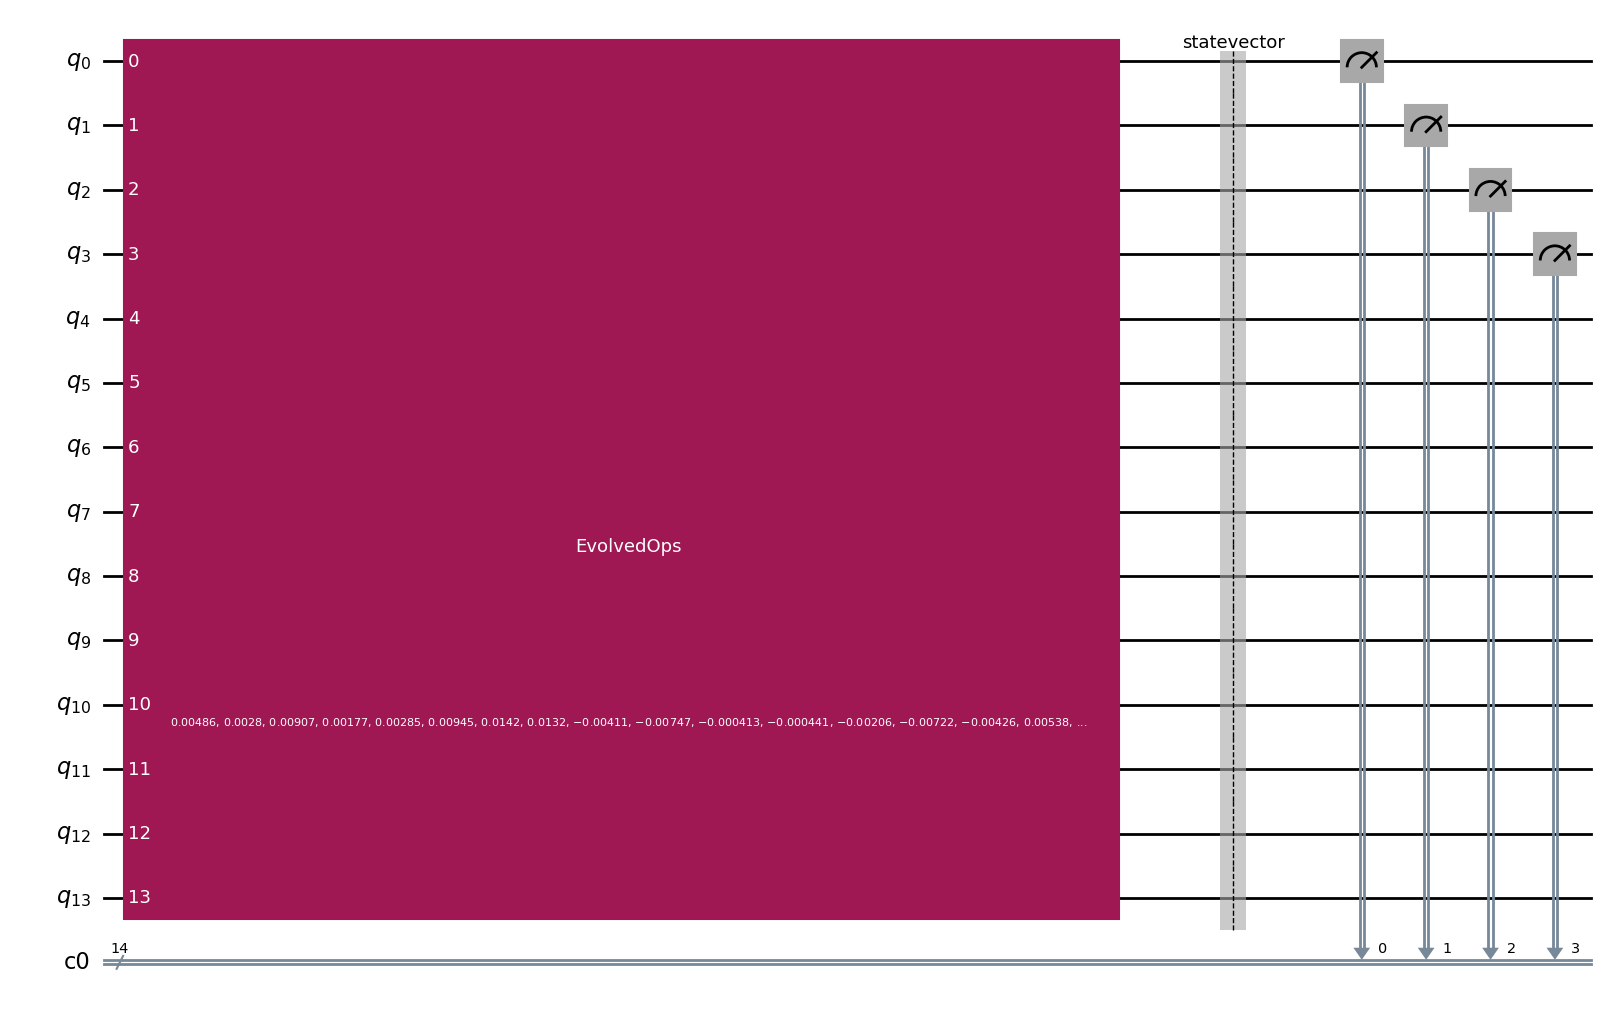

In [ ]:
# Estado cuántico

qc_bound = ansatz.assign_parameters({list(ansatz.parameters)[i]: res.x[i] for i in range(len(res.x))}) # Asignamos los parámetros al circuito

c_reg = ClassicalRegister(ansatz.num_qubits) # Añadimos un bit clásico a qc_bound
qc_bound.add_register(c_reg)

qc_bound.save_statevector() # Guardamos el estado antes de la medida

qc_bound.measure(range(4),range(4)) # Medimos

qc_bound.draw("mpl", style="iqp") # Dibujamos

Statevector([-3.79397928e-33+3.82114068e-33j,
              1.35998658e-32-1.41939931e-32j,
             -2.85984649e-34+6.89830926e-33j, ...,
             -1.65068875e-17+7.64528591e-18j,
             -2.93367168e-17-9.03924582e-17j,
              2.32206475e-16-2.72425169e-16j],
            dims=(2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2))


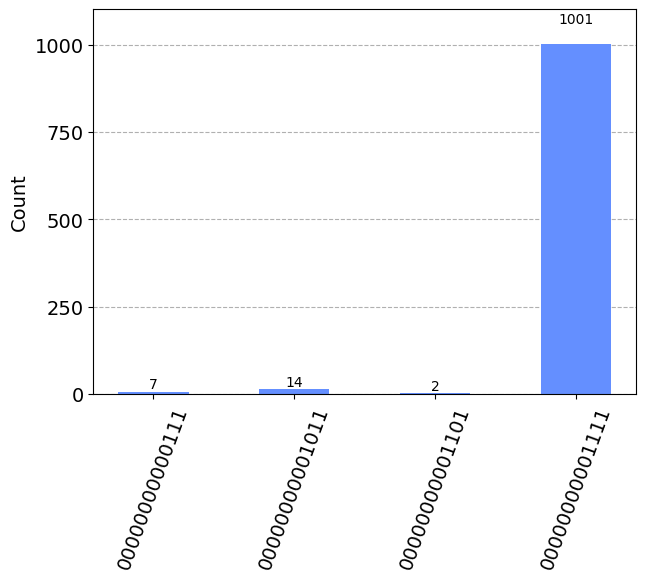

In [26]:
# Simulamos

sim = Aer.get_backend('qasm_simulator')
my_circuit = transpile(qc_bound, sim)
job = sim.run(my_circuit)
result = job.result()

sv = result.get_statevector()
print(sv)

counts = result.get_counts()
plot_histogram(counts)